# Location-discovery algorithm

This notebook demonstrates the performance of the location-discovery algorithm (both single and batch modes) proposed in the paper, where relevant results can be found in Table 2, Section 5.1.2.

## 1. Preloading Packages and Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import cvxpy as cp
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import linprog
from scripts.estimation import *
from scripts.utils import *
from scripts.discovery import *

## 2. Synthetic Data Generation

We generate the synthetic arrival data from a Poisson process with an underlying MNL model as rider's choice probability. In this example, all arrival locations are generated from a uniform distribution within a square field inside the location bound.

In [2]:
rand_seed = 1
num_position = 5
bike_num = 20
lambd = 10
grid_size = 10
beta0 = 1
beta1_true = -1
T = 100
loc_bound = 5
bike_num,num_records,book_bike,book_index,dist, \
bike_loc,all_period,num_booked,cand_loc,true_loc, \
position_weight=gen_sync(rand_seed,num_position,bike_num,lambd,grid_size,beta0=beta0,beta1_true=beta1_true,T=T,loc_bound=loc_bound)

## 3. Implementation of the Location-Discovery Algorithm

The following snippets implement the location-discovery algorithm under the synthetic data generated above. The values of the MNL model parameters $\beta_0$ and $\beta_1$ are known here. We randomly initialize two locations and use our location-discovery algorithm to discover potential arrival locations. The location-discovery algorithm is stopped when out-of-sample validation likelihood decreases. After the discovery procedure, we trim locations with weights less than 0.01 for numerical stability

### 3.1 Single Discovery Mode 

The single discovery mode discovers location one at a time.  To find a new location to include, we begin our search by initializing a coarse Cartesian grid onto the square service region. We find the rider location in the grid that maximizes the partial derivative of the Lagrangian function. We then perform a second grid search that is confined to a smaller square region whose boundary is defined by the neighboring locations of the one selected from the first round. We again overlay a Cartesian grid with the same number of intersections onto this smaller square region and identify the location having the largest partial derivative.

### Stopping with Out-of-sample Likelihood

In [3]:
np.random.seed(seed=rand_seed)
train_data,test_data = gen_sync(rand_seed,num_position,bike_num,lambd,grid_size,beta0=beta0,beta1_true=beta1_true,T=T,loc_bound=loc_bound,split_data=True)
bike_num,num_records_train,book_bike_train,book_index_train,dist_train,bike_loc_train,train_period,num_booked_train,cand_loc,true_loc,position_weight = train_data
bike_num,num_records_test,book_bike_test,book_index_test,dist_test,bike_loc_test,test_period,num_booked_test,cand_loc,true_loc,position_weight = test_data
T_train = 0.8*T
T_test = 0.2*T
init_num = 2
cur_locnum = init_num
lkd = np.array([])
lkd = np.append(lkd,-np.inf)
loc_add = np.array([])
cur_loc = np.random.uniform(-loc_bound/2,loc_bound/2,(2,2))
beta1_cur = beta1_true
testlkd = [-np.inf,-np.inf,-np.inf]
while (testlkd[-1]>=testlkd[-2]) or (testlkd[-2]>=testlkd[-3]):
    if cur_locnum > init_num:
        cur_loc = np.vstack((cur_loc,loc_add))
        pre_w = cur_w
    cur_dist = caldist(cur_loc,bike_loc_train,bike_num)
    choice_prob = findchoice_prob(cur_locnum,cur_dist,beta0,beta1_cur,num_records_train,bike_num)
    cur_w = findw_EM(cur_locnum,cur_loc.reshape(1,-1,2),beta0,bike_num,num_records_train,bike_loc_train,book_bike_train,num_booked_train,
            book_index_train,train_period,T_train)
    cur_lkd = findlkd_no_constraint(cur_locnum,cur_dist,beta0,np.repeat(beta1_cur,cur_locnum).reshape(-1,1),cur_w,
                                bike_num,num_records_train,book_bike_train,book_index_train,num_booked_train,train_period)
    lkd = np.append(lkd,cur_lkd)

    test_dist = caldist(cur_loc,bike_loc_test,bike_num)
    cur_testlkd = findlkd_no_constraint(cur_locnum,test_dist,beta0,np.repeat(beta1_cur,cur_locnum).reshape(-1,1),cur_w,
                                    bike_num,num_records_test,book_bike_test,book_index_test,num_booked_test,test_period)
    testlkd = testlkd+[cur_testlkd]

    s = np.sum((1-np.sum(np.expand_dims(cur_w,1)*(1/(1+np.sum(np.exp(beta0+beta1_cur*cur_dist),axis=2))),axis=0))*train_period)
    dist_new = caldist(cand_loc,bike_loc_train,bike_num)
    grad1 = calgrad(num_booked_train,s,cand_loc.shape[1],beta0,beta1_cur,choice_prob,train_period,cur_w,dist_new
                ,bike_num,num_records_train,book_bike_train,book_index_train)
    loc_ind1 = np.argmax(grad1)

    cand_loc2 = gen_loc(loc_bound,grid_size,s=(grid_size-1)/2,coor=cand_loc[0,loc_ind1])
    dist_new2 = caldist(cand_loc2,bike_loc_train,bike_num)
    grad2 = calgrad(num_booked_train,s,cand_loc2.shape[1],beta0,beta1_cur,choice_prob,train_period,cur_w,dist_new2
                ,bike_num,num_records_train,book_bike_train,book_index_train)
    loc_add = cand_loc2[0,np.argmax(grad2)].reshape(1,2)
    cur_locnum = cur_locnum + 1

In [4]:
# Location trimming
thres = 0.01
num_loc = cur_w.shape[0]
disc_lkd = lkd[-1]
sel_ind = cur_w>thres
w_trim = cur_w[sel_ind]/np.sum(cur_w[sel_ind])
wasser_dist_disc = find_wasserstein(cur_loc[sel_ind,:],true_loc,w_trim,position_weight)
num_remains = np.sum(sel_ind)
trimmed_lkd = findlkd_no_constraint(np.sum(sel_ind),caldist(cur_loc[sel_ind,:],bike_loc,bike_num),\
                                    beta0,np.repeat(beta1_cur,np.sum(sel_ind)).reshape(-1,1),w_trim,
                                    bike_num,num_records,book_bike,book_index,num_booked,all_period)

print('Number of discovered locations:', num_remains)
print('The Wasserstein distance is:',wasser_dist_disc[0])
print('The log-likelihood value is:',trimmed_lkd)

Number of discovered locations: 6
The Wasserstein distance is: 3.164969730837989
The log-likelihood value is: -1800.5799016366973


### 3.2 Batch Discovery Mode

The batch discovery mode discovers multiple locations at a time that can potentially enlarge the log-likelihood value. In the first round, we discover and include all "local maximal" rider locations in the set whose partial derivatives of the Lagrangian are greater than those of their neighboring locations. After that, we conduct a second round grid search near all locations selected in the first round. 

### Stopping with Out-of-sample Likelihood

In [5]:
np.random.seed(rand_seed)
train_data,test_data = gen_sync(rand_seed,num_position,bike_num,lambd,grid_size,beta0=beta0,beta1_true=beta1_true,T=T,loc_bound=loc_bound,split_data=True)
bike_num,num_records_train,book_bike_train,book_index_train,dist_train,bike_loc_train,train_period,num_booked_train,cand_loc,true_loc,position_weight = train_data
bike_num,num_records_test,book_bike_test,book_index_test,dist_test,bike_loc_test,test_period,num_booked_test,cand_loc,true_loc,position_weight = test_data

T_train = 0.8*T
T_test = 0.2*T
init_num = 2
cur_locnum = init_num
lkd = np.array([])
lkd = np.append(lkd,-np.inf)
loc_add = np.array([])
cur_loc = np.random.uniform(-loc_bound/2,loc_bound/2,(2,2)) 
beta1_cur = beta1_true
testlkd = [-np.inf,-np.inf,-np.inf]
while (testlkd[-1]>=testlkd[-2]):
    if cur_locnum > init_num:
        cur_loc = np.vstack((cur_loc,loc_add))
        pre_w = cur_w
    cur_dist = caldist(cur_loc,bike_loc_train,bike_num)
    choice_prob = findchoice_prob(cur_locnum,cur_dist,beta0,beta1_cur,num_records_train,bike_num)
    cur_w = findw_EM(cur_locnum,cur_loc.reshape(1,-1,2),beta0,bike_num,num_records_train,bike_loc_train,book_bike_train,num_booked_train,
                book_index_train,train_period,T_train)
    cur_lkd = findlkd_no_constraint(cur_locnum,cur_dist,beta0,np.repeat(beta1_cur,cur_locnum).reshape(-1,1),cur_w,
                                    bike_num,num_records_train,book_bike_train,book_index_train,num_booked_train,train_period)
    lkd = np.append(lkd,cur_lkd)

    test_dist = caldist(cur_loc,bike_loc_test,bike_num)
    cur_testlkd = findlkd_no_constraint(cur_locnum,test_dist,beta0,np.repeat(beta1_cur,cur_locnum).reshape(-1,1),cur_w,
                                        bike_num,num_records_test,book_bike_test,book_index_test,num_booked_test,test_period)
    testlkd = testlkd+[cur_testlkd]

    s = np.sum((1-np.sum(np.expand_dims(cur_w,1)*(1/(1+np.sum(np.exp(beta0+beta1_cur*cur_dist),axis=2))),axis=0))*train_period)
    dist_new = caldist(cand_loc,bike_loc_train,bike_num)
    grad1 = calgrad(num_booked_train,s,cand_loc.shape[1],beta0,beta1_cur,choice_prob,train_period,cur_w,dist_new
                    ,bike_num,num_records_train,book_bike_train,book_index_train)
    loc_ind1 = sel_loc_max(grad1,grid_size)
    num_added = loc_ind1.shape[0]
    loc_add = np.zeros((num_added,2))
    for i,loc_ind in enumerate(loc_ind1):
        cand_loc2 = gen_loc(loc_bound,grid_size,s=(grid_size-1)/2,coor=cand_loc[0,loc_ind])
        dist_new = caldist(cand_loc2,bike_loc_train,bike_num)
        grad2 = calgrad(num_booked_train,s,cand_loc2.shape[1],beta0,beta1_cur,choice_prob,train_period,cur_w,dist_new
                        ,bike_num,num_records_train,book_bike_train,book_index_train)
        loc_add[i] = cand_loc2[0,np.argmax(grad2)]
    cur_locnum = cur_locnum + num_added

In [6]:
# Location trimming
thres = 0.01
sel_ind = cur_w>thres
w_trim = cur_w[sel_ind]/np.sum(cur_w[sel_ind])
wasser_dist_disc = find_wasserstein(cur_loc[sel_ind,:],true_loc,w_trim,position_weight)
num_remains = np.sum(sel_ind)
trimmed_lkd = findlkd_no_constraint(np.sum(sel_ind),caldist(cur_loc[sel_ind,:],bike_loc,bike_num),\
                                    beta0,np.repeat(beta1_true,np.sum(sel_ind)).reshape(-1,1),w_trim,
                                    bike_num,num_records,book_bike,book_index,num_booked,all_period)

print('Number of discovered locations:', num_remains)
print('The Wasserstein distance is:',wasser_dist_disc[0])
print('The log-likelihood value is:',trimmed_lkd)

Number of discovered locations: 17
The Wasserstein distance is: 1.6991133387222581
The log-likelihood value is: -1777.5191575924578


## 4. Visualization

We visualize the predicted locations and the underlying true locations with their corresponding weights over a Cartesian coordinate. We use triangles to represent the underlying true locations and circles to represent the predicted locations. Different colors represent different weights of the corresponding locations.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


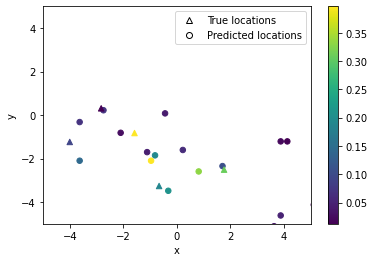

In [7]:
pred_loc = cur_loc[sel_ind,:]
pred_weight = w_trim

plt.scatter(pred_loc[:,0], pred_loc[:,1], c=pred_weight, s=30)
plt.scatter(true_loc[:,0], true_loc[:,1], c=position_weight, marker="^",s=30)
plt.xlim(-loc_bound,loc_bound)
plt.ylim(-loc_bound,loc_bound)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.colorbar()

blue_star = mlines.Line2D([], [], color='black', marker='^', linestyle='None', fillstyle='none',
                          markersize=6, label='True locations')
red_square = mlines.Line2D([], [], color='black', marker='o', linestyle='None',fillstyle='none',
                          markersize=6, label='Predicted locations')

plt.legend(handles=[blue_star, red_square])
plt.show()

## 5. Jointly estimating $\boldsymbol{w}$ and $\boldsymbol{\beta}_1$
We extend the location-discovery algorithm to jointly estimate the weight vector $\boldsymbol{w}$ and the slope $\boldsymbol{\beta}_1$ in the MNL model. Here, we assume that $\boldsymbol{\beta}_0$ is known to the operator and 
$\boldsymbol{\beta}_1$ is to be estimated. We further assume that $\boldsymbol{\beta}_0$ and $\boldsymbol{\beta}_1$ have the same value across all locations. All other setups are the same as before.

In [8]:
train_data,test_data = gen_sync(rand_seed,num_position,bike_num,lambd,grid_size,beta0=beta0,beta1_true=beta1_true,T=T,loc_bound=loc_bound,split_data=True)
bike_num,num_records_train,book_bike_train,book_index_train,dist_train,bike_loc_train,train_period,num_booked_train,cand_loc,true_loc,position_weight = train_data
bike_num,num_records_test,book_bike_test,book_index_test,dist_test,bike_loc_test,test_period,num_booked_test,cand_loc,true_loc,position_weight = test_data
T_train = 0.8*T
T_test = 0.2*T
init_num = 2

### 5.1 Single Mode

In [9]:
np.random.seed(seed=rand_seed)
loc_bound = 5

cur_locnum = init_num
lkd = np.array([])
lkd = np.append(lkd,-np.inf)
loc_add = np.array([])
cur_loc = np.random.uniform(-loc_bound/2,loc_bound/2,(2,2))
beta1_cur = np.random.uniform(-10,0)
beta1_rec = np.array([beta1_cur])
testlkd = [-np.inf,-np.inf,-np.inf,-np.inf]
while (testlkd[-1]>=testlkd[-2]) or (testlkd[-2]>=testlkd[-3]) or (cur_locnum<=5):
    if cur_locnum > init_num:
        cur_loc = np.vstack((cur_loc,loc_add))
        pre_w = cur_w
    cur_dist = caldist(cur_loc,bike_loc_train,bike_num)
    choice_prob = findchoice_prob(cur_locnum,cur_dist,beta0,beta1_cur,num_records_train,bike_num)

    beta1_cur,cur_w = findbetaw_EM(cur_locnum,cur_loc.reshape(1,-1,2),beta0,beta1_cur,bike_num,num_records_train,bike_loc_train,book_bike_train,num_booked_train,
                                    book_index_train,train_period,T_train)
    beta1_diff = np.abs((beta1_rec[-1]-beta1_cur)/beta1_rec[-1])
    beta1_rec = np.append(beta1_rec,beta1_cur)

    cur_lkd = findlkd_no_constraint(cur_locnum,cur_dist,beta0,np.repeat(beta1_cur,cur_locnum).reshape(-1,1),cur_w,
                                    bike_num,num_records_train,book_bike_train,book_index_train,num_booked_train,train_period)
    lkd = np.append(lkd,cur_lkd)

    test_dist = caldist(cur_loc,bike_loc_test,bike_num)
    cur_testlkd = findlkd_no_constraint(cur_locnum,test_dist,beta0,np.repeat(beta1_cur,cur_locnum).reshape(-1,1),cur_w,
                                        bike_num,num_records_test,book_bike_test,book_index_test,num_booked_test,test_period)
    testlkd = testlkd+[cur_testlkd]

    s = np.sum((1-np.sum(np.expand_dims(cur_w,1)*(1/(1+np.sum(np.exp(beta0+beta1_cur*cur_dist),axis=2))),axis=0))*train_period)
    dist_new = caldist(cand_loc,bike_loc_train,bike_num)
    grad1 = calgrad(num_booked_train,s,cand_loc.shape[1],beta0,beta1_cur,choice_prob,train_period,cur_w,dist_new
                    ,bike_num,num_records_train,book_bike_train,book_index_train)
    loc_ind1 = np.argmax(grad1)

    cand_loc2 = gen_loc(loc_bound,grid_size,s=(grid_size-1)/2,coor=cand_loc[0,loc_ind1])
    dist_new2 = caldist(cand_loc2,bike_loc_train,bike_num)
    grad2 = calgrad(num_booked_train,s,cand_loc2.shape[1],beta0,beta1_cur,choice_prob,train_period,cur_w,dist_new2
                    ,bike_num,num_records_train,book_bike_train,book_index_train)
    loc_add = cand_loc2[0,np.argmax(grad2)].reshape(1,2)
    cur_locnum = cur_locnum + 1

sel_ind = cur_w>0.01
w_trim = cur_w[sel_ind]
w_trim = w_trim/np.sum(w_trim)
was_dist_disc = find_wasserstein(cur_loc[sel_ind,:],true_loc,w_trim,position_weight)[0]
num_remains = np.sum(sel_ind)
trimmed_lkd = findlkd_no_constraint(np.sum(sel_ind),caldist(cur_loc[sel_ind,:],bike_loc,bike_num),
                                    beta0,np.repeat(beta1_cur,np.sum(sel_ind)).reshape(-1,1),w_trim,
                                    bike_num,num_records,book_bike,book_index,num_booked,all_period)

MAPE = np.abs(beta1_cur-beta1_true)/-beta1_true

In [10]:
print('The MAPE of beta1 is:',MAPE)
print('The Wasserstein distance is:',was_dist_disc)
print('The log-likelihood value is:',trimmed_lkd)

The MAPE of beta1 is: 0.07608259670408479
The Wasserstein distance is: 3.0957378715016777
The log-likelihood value is: -1777.8437464417043


### 5.2 Batch mode

In [11]:
np.random.seed(seed=rand_seed)
loc_bound = 5

cur_locnum = init_num
lkd = np.array([])
lkd = np.append(lkd,-np.inf)
loc_add = np.array([])
cur_loc = np.random.uniform(-loc_bound/2,loc_bound/2,(2,2))
beta1_cur = np.random.uniform(-10,0)
beta1_rec = np.array([beta1_cur])
testlkd = [-np.inf,-np.inf,-np.inf]
while (testlkd[-1]>=testlkd[-2]) or (cur_locnum<=5):
    if cur_locnum > init_num:
        cur_loc = np.vstack((cur_loc,loc_add))
        pre_w = cur_w
    cur_dist = caldist(cur_loc,bike_loc_train,bike_num)
    choice_prob = findchoice_prob(cur_locnum,cur_dist,beta0,beta1_cur,num_records_train,bike_num)
    beta1_cur,cur_w = findbetaw_EM(cur_locnum,cur_loc.reshape(1,-1,2),beta0,beta1_cur,bike_num,num_records_train,bike_loc_train,book_bike_train,num_booked_train,
                                    book_index_train,train_period,T_train)
    beta1_diff = np.abs((beta1_rec[-1]-beta1_cur)/beta1_rec[-1])
    beta1_rec = np.append(beta1_rec,beta1_cur)
    cur_lkd = findlkd_no_constraint(cur_locnum,cur_dist,beta0,np.repeat(beta1_cur,cur_locnum).reshape(-1,1),cur_w,
                                    bike_num,num_records_train,book_bike_train,book_index_train,num_booked_train,train_period)
    lkd = np.append(lkd,cur_lkd)

    test_dist = caldist(cur_loc,bike_loc_test,bike_num)
    cur_testlkd = findlkd_no_constraint(cur_locnum,test_dist,beta0,np.repeat(beta1_cur,cur_locnum).reshape(-1,1),cur_w,
                                        bike_num,num_records_test,book_bike_test,book_index_test,num_booked_test,test_period)
    testlkd = testlkd+[cur_testlkd]

    s = np.sum((1-np.sum(np.expand_dims(cur_w,1)*(1/(1+np.sum(np.exp(beta0+beta1_cur*cur_dist),axis=2))),axis=0))*train_period)
    dist_new = caldist(cand_loc,bike_loc_train,bike_num)
    grad1 = calgrad(num_booked_train,s,cand_loc.shape[1],beta0,beta1_cur,choice_prob,train_period,cur_w,dist_new
                    ,bike_num,num_records_train,book_bike_train,book_index_train)
    loc_ind1 = sel_loc_max(grad1,grid_size)
    num_added = loc_ind1.shape[0]
    loc_add = np.zeros((num_added,2))
    for i,loc_ind in enumerate(loc_ind1):
        cand_loc2 = gen_loc(loc_bound,grid_size,s=(grid_size-1)/2,coor=cand_loc[0,loc_ind])
        dist_new = caldist(cand_loc2,bike_loc_train,bike_num)
        grad2 = calgrad(num_booked_train,s,cand_loc2.shape[1],beta0,beta1_cur,choice_prob,train_period,cur_w,dist_new
                        ,bike_num,num_records_train,book_bike_train,book_index_train)
        loc_add[i] = cand_loc2[0,np.argmax(grad2)]
    cur_locnum = cur_locnum + num_added

sel_ind = cur_w>0.01
w_trim = cur_w[sel_ind]
w_trim = w_trim/np.sum(w_trim)
was_dist_disc = find_wasserstein(cur_loc[sel_ind,:],true_loc,w_trim,position_weight)[0]
num_remains = np.sum(sel_ind)
trimmed_lkd = findlkd_no_constraint(np.sum(sel_ind),caldist(cur_loc[sel_ind,:],bike_loc,bike_num),
                                    beta0,np.repeat(beta1_cur,np.sum(sel_ind)).reshape(-1,1),w_trim,
                                    bike_num,num_records,book_bike,book_index,num_booked,all_period)
MAPE = np.abs(beta1_cur-beta1_true)/-beta1_true

In [12]:
print('The MAPE of beta1 is:',MAPE)
print('The Wasserstein distance is:',was_dist_disc)
print('The log-likelihood value is:',trimmed_lkd)

The MAPE of beta1 is: 0.2774724863939786
The Wasserstein distance is: 3.641833458728626
The log-likelihood value is: -1822.8202491866264
